# 观察天气数据集的数据

In [1]:
import os
data_dir = r'/data/dataset/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


# 解析数据

In [2]:
import numpy as np
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

# 绘制温度时间序列

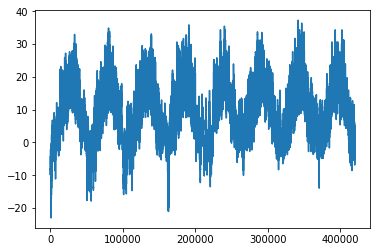

In [4]:
from matplotlib import pyplot as plt
temp = float_data[:, 1]  # 温度数据列
plt.plot(range(len(temp)), temp)

# 绘制前10天的温度时间序列

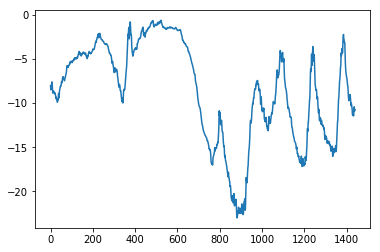

In [5]:
plt.plot(range(1440), temp[:1440])

# 数据标准化

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:20000].std(axis=0)
float_data /= std

# 生成时间序列样本及其目标的生成器

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data)-delay-1
    i = min_index+lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if i+batch_size >= max_index:
                i = min_index+lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i  += len(rows)
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

# 准备训练生成器,验证生成器和测试生成器

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)
val_steps = (300000-200001-lookback) // batch_size
test_steps = (len(float_data)-300001-lookback) // batch_size


# 计算符合常识的基准方法的MAE

In [9]:
def evaluate_naive_method():
    batch_maes = list()
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.335517562861696


# 将MAE转换成摄氏温度误差

In [10]:
celsius_mae = 0.3355 * std[1]
celsius_mae

2.5647531744580285

# 训练并评估一个密集连接模型

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20
500/500 [==============================] - 6s 12ms/step - loss: 2.2361 - val_loss: 1.1068
Epoch 2/20
500/500 [==============================] - 5s 11ms/step - loss: 0.7254 - val_loss: 0.4255
Epoch 3/20
500/500 [==============================] - 5s 11ms/step - loss: 0.3614 - val_loss: 0.3655
Epoch 4/20
500/500 [==============================] - 5s 11ms/step - loss: 0.3178 - val_loss: 0.3451
Epoch 5/20
500/500 [==============================] - 5s 11ms/step - loss: 0.3051 - val_loss: 0.3470
Epoch 6/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2933 - val_loss: 0.3580
Epoch 7/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2852 - val_loss: 0.3872
Epoch 8/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2784 - val_loss: 0.4255
Epoch 9/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2735 - val_loss: 0.4036
Epoch 10/20
500/500 [==============================] - 5s 11ms/step - loss: 0.2672 - val_lo

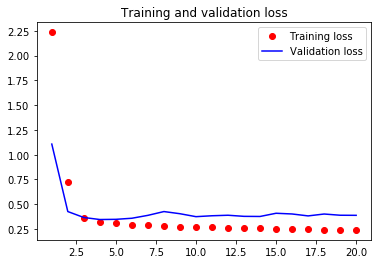

In [14]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 训练并评估一个基于GRU的模型

In [16]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20
500/500 [==============================] - 90s 180ms/step - loss: 0.3500 - val_loss: 0.3232
Epoch 2/20
500/500 [==============================] - 89s 179ms/step - loss: 0.3254 - val_loss: 0.3116
Epoch 3/20
500/500 [==============================] - 90s 180ms/step - loss: 0.3211 - val_loss: 0.3119
Epoch 4/20
500/500 [==============================] - 89s 179ms/step - loss: 0.3149 - val_loss: 0.3076
Epoch 5/20
500/500 [==============================] - 89s 178ms/step - loss: 0.3073 - val_loss: 0.3084
Epoch 6/20
500/500 [==============================] - 88s 176ms/step - loss: 0.3034 - val_loss: 0.3070
Epoch 7/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2954 - val_loss: 0.3078
Epoch 8/20
500/500 [==============================] - 88s 177ms/step - loss: 0.2925 - val_loss: 0.3122
Epoch 9/20
500/500 [==============================] - 89s 178ms/step - loss: 0.2863 - val_loss: 0.3129
Epoch 10/20
500/500 [==============================] - 88s 177ms/step - l

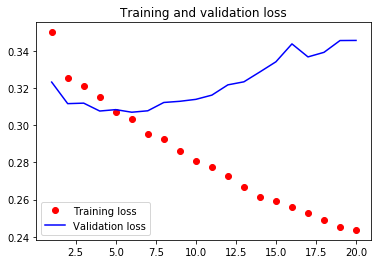

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
0.31*std[1]

# 训练并评估一个使用dropout正则化的基于GRU的模型

Epoch 1/40
500/500 [==============================] - 103s 207ms/step - loss: 0.3895 - val_loss: 0.3207
Epoch 2/40
500/500 [==============================] - 103s 207ms/step - loss: 0.3655 - val_loss: 0.3202
Epoch 3/40
500/500 [==============================] - 103s 206ms/step - loss: 0.3555 - val_loss: 0.3101
Epoch 4/40
500/500 [==============================] - 102s 205ms/step - loss: 0.3513 - val_loss: 0.3122
Epoch 5/40
500/500 [==============================] - 104s 209ms/step - loss: 0.3490 - val_loss: 0.3127
Epoch 6/40
500/500 [==============================] - 103s 207ms/step - loss: 0.3444 - val_loss: 0.3084
Epoch 7/40
500/500 [==============================] - 103s 206ms/step - loss: 0.3437 - val_loss: 0.3095
Epoch 8/40
500/500 [==============================] - 104s 207ms/step - loss: 0.3404 - val_loss: 0.3088
Epoch 9/40
500/500 [==============================] - 104s 208ms/step - loss: 0.3395 - val_loss: 0.3107
Epoch 10/40
500/500 [==============================] - 104s 207m

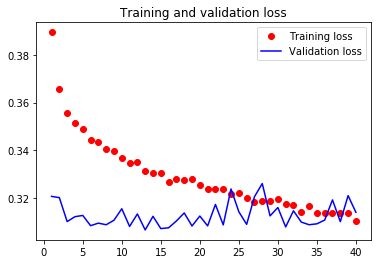

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 训练并评估一个使用dropout正则化的堆叠GRU模型

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 使用逆序序列训练并评估一个LSTM

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_feaures = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 将序列反转
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]
# 序列填充
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequece.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    x_train, 
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2
)

loss = history.history['acc']
val_loss = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

# 训练并评估一个双向LSTM

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)
history =  model.fit(
    x_train, 
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2
)

loss = history.history['acc']
val_loss = history.history['val_acc']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.show()

# 训练一个双向GRU

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss='mae'
)

history = model.fit_generator(
    train_gen,
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)